In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from sessions import selected_008229, selected_013608, selected_013829
from imports import *
from scipy import stats
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from correlation import cluster_corr
import matplotlib.animation as animation

from spiketrain import inst_rate

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source = '/Users/andrey/nevermind/AG_Pecka/data/processed/'

rep_path = '/home/sobolev/nevermind_ag-grothe/Andrey/analysis/PPC/video'

#selected = selected_013829
selected = selected_013608
selected[:]

['013608_ppcSIT_2025-01-06_13-20-52',
 '013608_ppcSIT_2025-01-07_08-47-27',
 '013608_ppcSIT_2025-01-07_15-38-23',
 '013608_ppcSIT_2025-01-09_09-09-55',
 '013608_ppcSIT_2025-01-10_09-25-04',
 '013608_ppcSIT_2025-01-13_14-01-40',
 '013608_ppcSIT_2025-01-14_10-20-14',
 '013608_ppcSIT_2025-01-15_14-56-18',
 '013608_ppcSIT_2025-01-16_09-49-21',
 '013608_ppcSIT_2025-01-17_10-07-00',
 '013608_ppcSIT_2025-01-20_09-38-20',
 '013608_ppcSIT_2025-01-21_08-50-02',
 '013608_ppcSIT_2025-01-22_12-59-00',
 '013608_ppcSIT_2025-01-23_08-46-51',
 '013608_ppcSIT_2025-01-24_08-19-45',
 '013608_ppcSIT_2025-01-27_09-00-20',
 '013608_ppcSIT_2025-01-29_12-34-08',
 '013608_ppcSIT_2025-02-18_14-15-52',
 '013608_ppcSIT_2025-02-19_13-50-59',
 '013608_ppcSIT_2025-02-27_08-56-52',
 '013608_ppcSIT_2025-02-28_16-23-29',
 '013608_ppcSIT_2025-03-03_08-55-30',
 '013608_ppcSIT_2025-03-04_09-17-16',
 '013608_ppcSIT_2025-03-05_10-33-41']

In [155]:
session = selected[13]
#session = '013608_ppcSIT_2025-01-15_14-56-18'
#session = '013829_ppcSIT_2024-11-16_11-17-54'
#session = '013608_ppcSIT_2025-03-05_10-33-41'
session

'013608_ppcSIT_2025-01-23_08-46-51'

## Load units

In [156]:
animal = session.split('_')[0]

s_path     = os.path.join(source, animal, session)
meta_file  = os.path.join(s_path, 'meta.h5')
unit_file  = os.path.join(s_path, 'units.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])
    trials = np.array(f['processed']['trial_idxs'])

In [157]:
single_units, spike_times, single_units_100 = {}, {}, {}
with h5py.File(unit_file, 'r') as f:
    unit_names = [x for x in f]
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
        single_units_100[unit_name] = inst_rate(spike_times[unit_name], tl[:, 0], k_width=100)

In [158]:
len(single_units)

170

## 1. Hierarchical clustering

In [159]:
# using correlation matrix - slow

# l = len(unit_names)
# corr_pearson, corr_spearman = np.zeros((l, l)), np.zeros((l, l))
# for i, u1 in enumerate(unit_names):
#     for j, u2 in enumerate(unit_names):
#         i_rate1 = single_units[u1]
#         i_rate2 = single_units[u2]

#         corr_pearson[i, j]  = stats.pearsonr(i_rate1, i_rate2)[0]
#         #corr_spearman[i, j] = stats.spearmanr(i_rate1, i_rate2)[0]

In [160]:
# using covariance matrix - fast
#unit_mx = np.array([single_units_100[u] for u in unit_names])
unit_mx = np.array([single_units[u] for u in unit_names])

cov_mx = np.cov(unit_mx)

cov_max = 10
#cov_max = 0.0000005
cov_mx[cov_mx > cov_max] = cov_max
cov_mx[cov_mx < -cov_max] = -cov_max

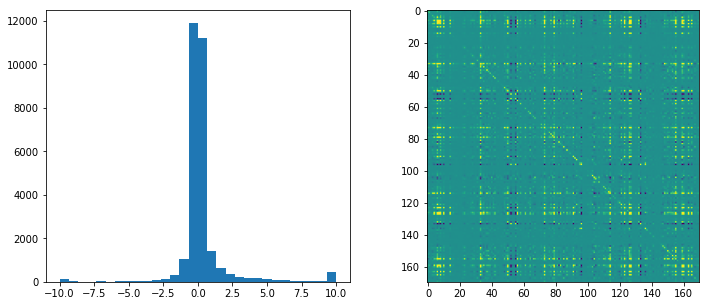

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(cov_mx.flatten(), bins=30)
axes[1].imshow(cov_mx)

In [165]:
#corr_srt, Z, labels, idxs_sort = cluster_corr(corr_pearson, threshold=2.6)
#corr_srt, Z, labels, idxs_sort = cluster_corr(cov_mx, threshold=0.000001)
corr_srt, Z, labels, idxs_sort = cluster_corr(cov_mx, threshold=45)
labels_dict = dict([(u, l) for u, l in zip(unit_names, labels)])

In [166]:
units_sorted = [unit_names[i] for i in idxs_sort]

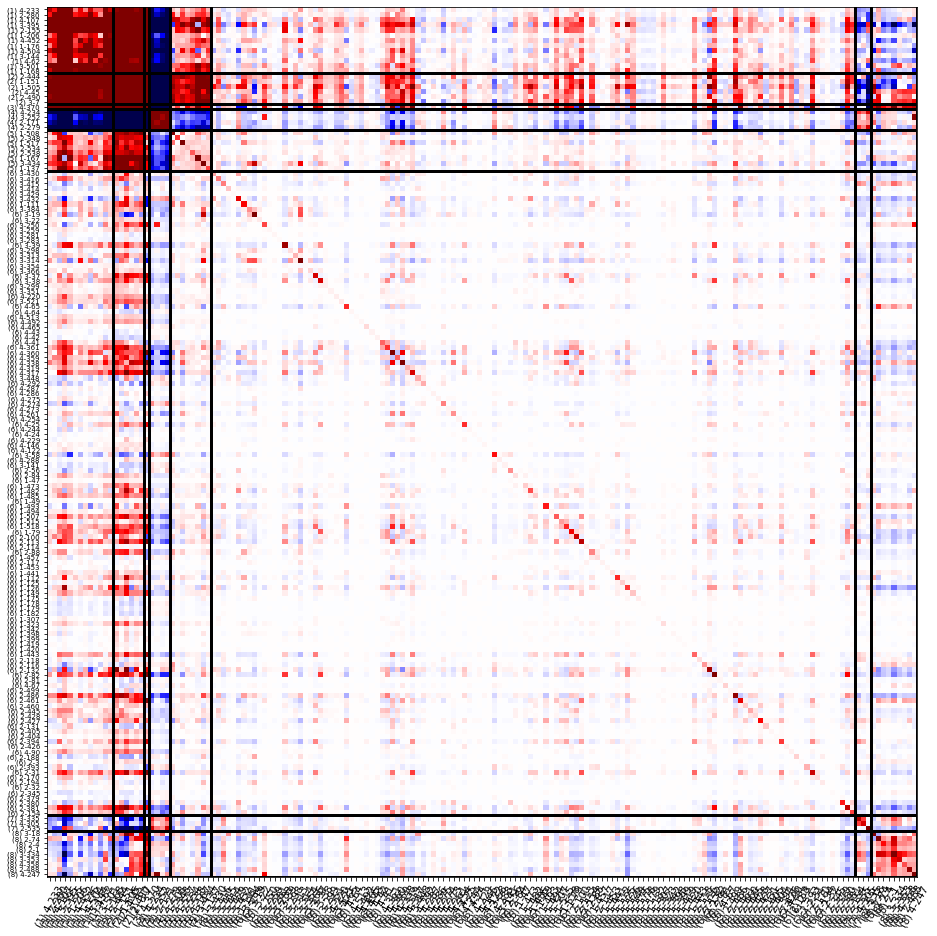

In [167]:
tick_labels = ["(%s) %s" % (labels_dict[u], u) for u in units_sorted]

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
ax.imshow(corr_srt, cmap='seismic')
ax.set_xticks(range(corr_srt.shape[0]))
ax.set_xticklabels(tick_labels, rotation=60)
ax.set_yticks(range(corr_srt.shape[0]))
_ = ax.set_yticklabels(tick_labels, fontsize=7)
for clu_no in set(labels):
    l_pos = np.where(labels[idxs_sort] == clu_no)[0][-1] + 0.5
    ax.axhline(l_pos, color='black', lw=3)
    ax.axvline(l_pos, color='black', lw=3)

In [174]:
# unit names having particular labels
[unit for unit, label in labels_dict.items() if label in (5,)]

['1-137', '1-167', '1-508', '1-517', '2-348', '2-534', '2-538', '3-434']

In [16]:
# save to json 
to_save = [
    [unit_names[j] for j in idxs_sort],
    [int(labels[j]) for j in idxs_sort]
]

jf_name = os.path.join(s_path, 'analysis', 'units_cov_clu.json')
with open(jf_name, 'w') as f:
    f.write(json.dumps(to_save))

In [247]:
with open(jf_name, 'r') as f:
    units_data  = json.load(f)
    unit_names  = units_data[0]
    unit_labels = units_data[1]

## 2. Use PCA to cluster units

In [21]:
from sklearn import decomposition

pca_unit_mx = decomposition.PCA(n_components=20)
pca_unit_mx.fit(cov_mx)
X = pca_unit_mx.transform(cov_mx)

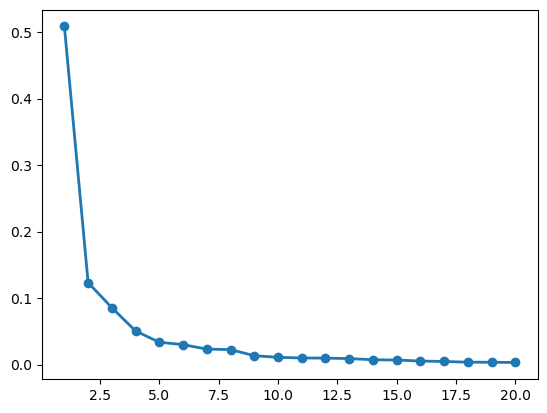

In [20]:
# scree plot
PC_values = np.arange(pca_unit_mx.n_components_) + 1
plt.plot(PC_values, pca_unit_mx.explained_variance_ratio_, 'o-', linewidth=2)

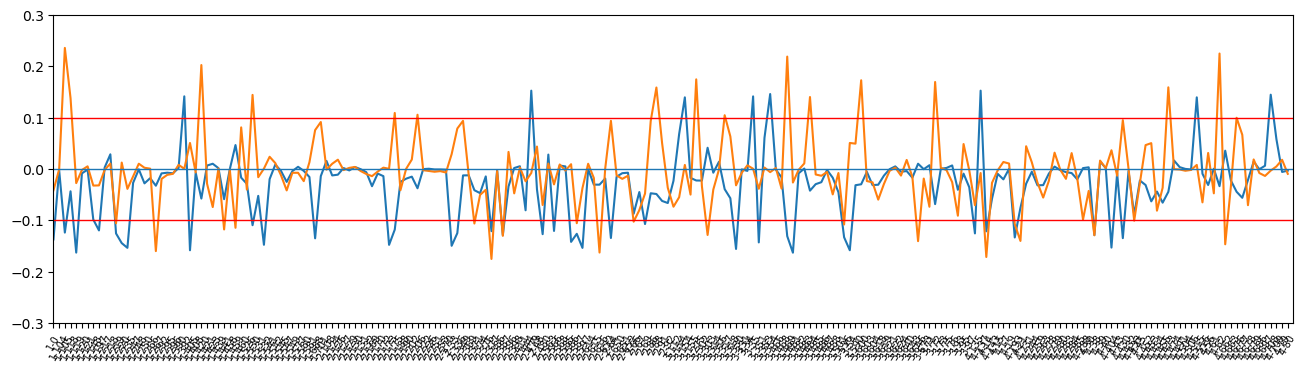

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

ax.plot(pca_unit_mx.components_[0])
ax.plot(pca_unit_mx.components_[1])
ax.set_xticks(range(len(unit_names)))
ax.set_xticklabels(unit_names, rotation=60, fontsize=7)
ax.set_xlim(0, len(unit_names))
ax.set_ylim(-0.3, 0.3)
ax.axhline(0, lw=1)
ax.axhline( 0.1, lw=1, color='red')
ax.axhline(-0.1, lw=1, color='red')

In [22]:
[unit_names[i] for i in np.where(pca_unit_mx.components_[0] > 0.1)[0]]

['1-392', '2-479', '3-154', '3-35', '3-354', '4-137', '4-515', '4-708']

In [204]:
[unit_names[i] for i in np.where(pca_unit_mx.components_[0] < -0.1)[0]]

['1-32', '1-37', '2-9', '3-2', '4-2', '4-7', '7-15', '7-16', '7-17', '8-16']

## Ensemble mean

In [71]:
# timeline resolution
ensemble_ids = [unit for unit, label in labels_dict.items() if label in (1,)]

ensemble_mx = np.zeros([len(ensemble_ids), len(tl)])
for i, unit_id in enumerate(ensemble_ids):
    ensemble_mx[i] = inst_rate(spike_times[unit_id], tl[:, 0], k_width=50)
    ensemble_mx[i] = stats.zscore(ensemble_mx[i])
    
# speed correlation
np.corrcoef(ensemble_mx.mean(axis=0), tl[:, 3])[0][1]

-0.3696608497995432

In [83]:
ensembles_f = os.path.join(s_path, 'analysis', 'ensembles.h5')
with h5py.File(ensembles_f, 'w') as f:
    f.create_dataset('AL', data=ensemble_mx.mean(axis=0))

## Plot fire matrix

In [68]:
# timeline indices
idxs_target = np.where(tl[:, 6] == 2)[0]
idxs_backgr = np.where(tl[:, 6] == 1)[0]
idxs_noise  = np.where(tl[:, 6] ==-1)[0]
idxs_di1    = np.where(tl[:, 6] == 3)[0]
idxs_di2    = np.where(tl[:, 6] == 4)[0]
#idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)  # another way
idxs_reward = tgt_mx[tgt_mx[:, 4] == 1][:, 3]

# events
idxs_to_idx = np.where(np.diff(idxs_backgr) > 5)[0] + 1
idxs_bgr_start = idxs_backgr[:-1][idxs_to_idx]
idxs_to_idx = np.where(np.diff(idxs_noise) > 5)[0] + 1
#idxs_nos_start = np.concatenate([[idxs_noise[0]], idxs_noise[:-1][idxs_to_idx]])
idxs_tgt_start = tgt_mx[:, 2]

In [69]:
# print out number of frames
#out_path = os.path.join(rep_path, 'video_labeled.mp4')
#cap = cv2.VideoCapture(out_path)
#nt(cap.get(cv2.CAP_PROP_FRAME_COUNT)), 60*40*20

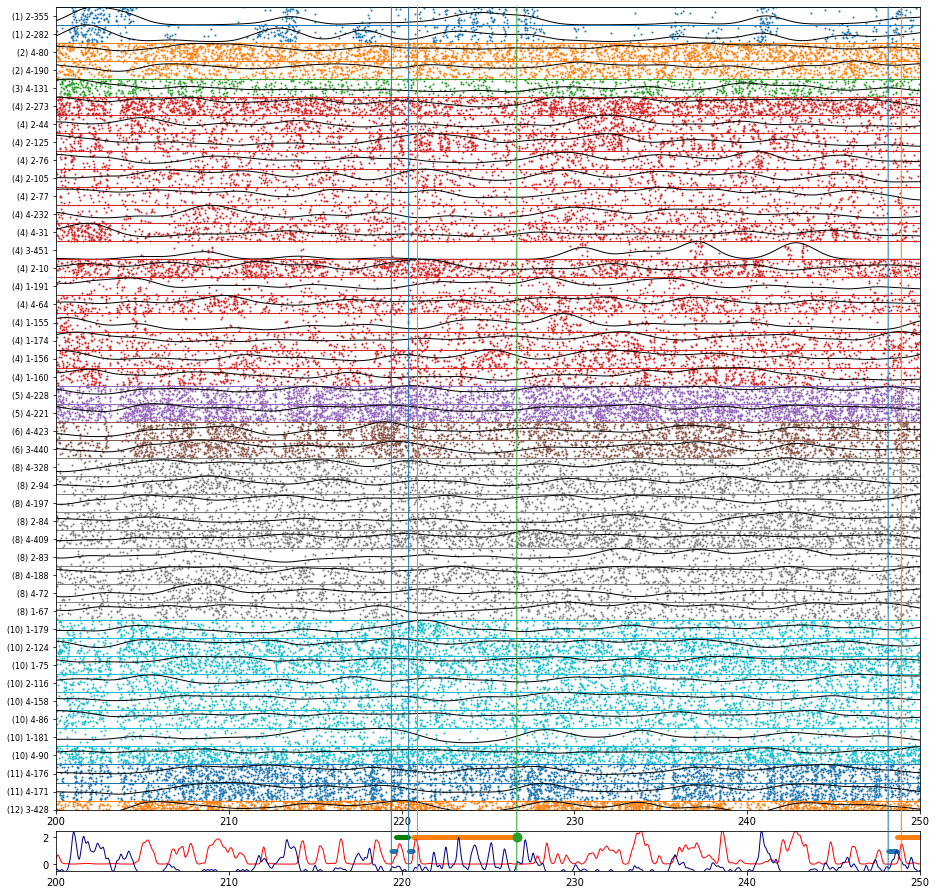

In [75]:
clu_to_exclude = [7, 9]
idxs_to_plot = [i for i, u_n in enumerate(units_sorted) if not labels_dict[u_n] in clu_to_exclude]

t_l, t_r = 200, 250  # in seconds
#u_id_min, u_id_max = 0, len(units_sorted)
#u_id_diff = u_id_max - u_id_min

colors = list((plt.rcParams['axes.prop_cycle'].by_key()['color']))
colors = colors + colors

# 9.055 gives without margins 768px height, but quality is shit
#fig = plt.figure(figsize=(9.055, 9.055))#, frameon=False, dpi=100)
fig = plt.figure(figsize=(15, 15))#, frameon=False, dpi=100)
gs = fig.add_gridspec(2, 1, height_ratios=(20, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# units
ax1 = fig.add_subplot(gs[0])
idxs_tl = np.where((tl[:, 0] > t_l) & (tl[:, 0] < t_r))[0]

#for i, unit_name in enumerate(units_sorted[u_id_min:u_id_max][::-1]):
units_to_plot = [u_n for i, u_n in enumerate(units_sorted) if i in idxs_to_plot]
for i, unit_name in enumerate(units_to_plot):
    i_rate = single_units[unit_name]
    s_times = spike_times[unit_name]
    s_vals = np.random.rand(len(s_times))
    #clr = colors[labels[idxs_sort][i] - 1]
    clr = colors[labels_dict[unit_name]-1]
    
    idxs_ts = np.where((s_times > t_l) & (s_times < t_r))[0]
    
    ax1.scatter(s_times[idxs_ts], s_vals[idxs_ts] + len(idxs_to_plot) - (i+1), s=1, color=clr)
    ax1.axhline(len(idxs_to_plot) - i, color=clr, lw=1)
    
    i_max = i_rate[idxs_tl].max()
    ax1.plot(tl[:, 0][idxs_tl], i_rate[idxs_tl]/i_max + len(idxs_to_plot) - (i+1), lw=1, color='black')
    
ax1.set_xlim(t_l, t_r)
ax1.set_ylim(1, len(idxs_to_plot))
ax1.set_yticks(np.arange(len(idxs_to_plot)) + 0.5)
labels_to_plot = [label for i, label in enumerate(tick_labels) if i in idxs_to_plot]
#_ = ax1.set_yticklabels(list(reversed(tick_labels)), fontsize=8)  # reversed
_ = ax1.set_yticklabels(list(reversed(labels_to_plot)), fontsize=8)

#ax1.margins(x=0)

# experimental timeline 
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.scatter(tl[idxs_target][:, 0], 2*np.ones(len(idxs_target)), s=1, color=colors[1], lw=3)
ax2.scatter(tl[idxs_backgr][:, 0], 1*np.ones(len(idxs_backgr)), s=1, color=colors[0], lw=3)
ax2.scatter(tl[idxs_noise][:, 0],  0*np.ones(len(idxs_noise)),  s=1, color=colors[3], lw=3)
ax2.scatter(tl[idxs_di1][:, 0],  2*np.ones(len(idxs_di1)),  s=1, color='navy', lw=3)
ax2.scatter(tl[idxs_di2][:, 0],  2*np.ones(len(idxs_di2)),  s=1, color='green', lw=3)
ax2.scatter(tl[idxs_noise][:, 0],  0*np.ones(len(idxs_noise)),  s=1, color=colors[3], lw=3)
ax2.scatter(tl[idxs_reward][:, 0], 2 * np.ones(len(idxs_reward)), s=50, color=colors[2], lw=3)
ax2.set_ylim(-0.5, 2.5)

# speed
#ensemble_mean = inst_rate(spike_times['1-111'], tl[:, 0], k_width=50)
ensemble_mean = ensemble_mx.mean(axis=0)
s_max = tl[idxs_tl][:, 3].max()
e_max = ensemble_mean[idxs_tl].max()
ax2.plot(tl[idxs_tl][:, 0], (tl[idxs_tl][:, 3]/s_max)*2.5, lw=1, color='red')
ax2.plot(tl[idxs_tl][:, 0], (ensemble_mean[idxs_tl]/e_max)*2.5, lw=1, color='navy')

#ax2.margins(x=0)
#fig.tight_layout()

# vertical lines
events_to_plot = events[(events[:, 0] > t_l) & (events[:, 0] < t_r)][:, 2].astype(np.int32)  # FIXME use exact time
v_min, v_max = -0.5, len(idxs_to_plot)
lines_to_plot = [idxs_bgr_start, idxs_tgt_start, idxs_reward] #, events_to_plot]
for j, idxs_var in enumerate(lines_to_plot):
    xy1 = np.vstack([ tl[idxs_var][:, 0], v_max * np.ones(len(idxs_var)) ]).T
    xy3 = np.vstack([ tl[idxs_var][:, 0], v_min * np.ones(len(idxs_var)) ]).T
    for i in range(len(idxs_var)):
        if xy1[i][0] < t_l or xy1[i][0] > t_r:
            continue
        con = ConnectionPatch(xyA=xy1[i], coordsA=ax1.transData, xyB=xy3[i], coordsB=ax2.transData, color=colors[j])
        fig.add_artist(con)


In [60]:
# unit names having particular labels
[unit for unit, label in labels_dict.items() if label in (2,)]

['1-143',
 '1-157',
 '1-161',
 '1-518',
 '2-147',
 '2-460',
 '2-500',
 '3-501',
 '3-59',
 '3-8',
 '4-232',
 '4-25',
 '4-368',
 '4-434']

In [16]:
diffs = []
for spike in spike_times['2-362']:
    idx_closest = np.abs(spike_times['3-114'] - spike).argmin()
    diffs.append(spike_times['3-114'][idx_closest] - spike)
diffs = np.array(diffs)

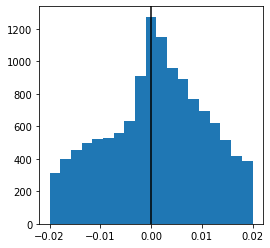

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.hist(diffs, bins=np.linspace(-0.02, 0.02, 20))
ax.axvline(0, color='black')

### Ensemble statistics

In [142]:
idxs_bgr_ev = np.where(events[:, 1] == 1)[0]

idxs_bgr_tl = events[idxs_bgr_ev][:, 2].astype(np.int32)
ensemble_mean_ev = ensemble_mean[idxs_bgr_tl]
len(np.where(ensemble_mean_ev > 0)[0]), len(np.where(ensemble_mean_ev < 0)[0])

(1046, 1951)

(array([945., 524., 380., 202., 168., 132., 131.,  92.,  96.,  85.,  66.,
         58.,  41.,  24.,  20.,  13.,  10.,   2.,   4.,   4.]),
 array([-0.77980854, -0.55572744, -0.33164633, -0.10756522,  0.11651588,
         0.34059699,  0.5646781 ,  0.7887592 ,  1.01284031,  1.23692142,
         1.46100252,  1.68508363,  1.90916474,  2.13324584,  2.35732695,
         2.58140806,  2.80548916,  3.02957027,  3.25365138,  3.47773248,
         3.70181359]),
 <BarContainer object of 20 artists>)

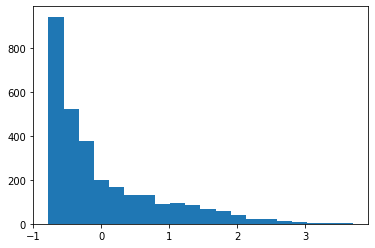

In [143]:
plt.hist(ensemble_mean_ev, bins=20)

### Selected units timeline to look for corrs

(50000.0, 150000.0)

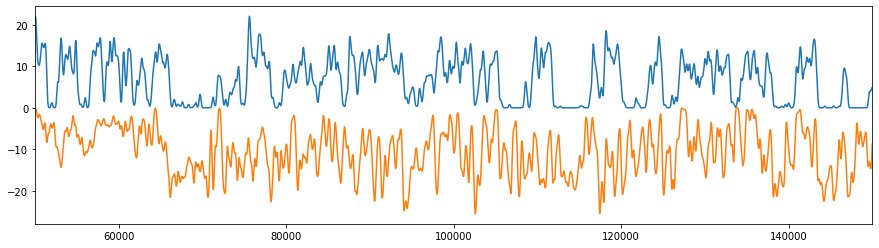

In [444]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(single_units['8-8'])
ax.plot(-single_units['7-16'])
#ax.plot(single_units['8-10'])
ax.set_xlim(50000, 150000)

## Animation

In [ ]:
# ----- time animation line
# https://matplotlib.org/stable/gallery/animation/multiple_axes.html#sphx-glr-gallery-animation-multiple-axes-py
# https://stackoverflow.com/questions/31252107/how-to-draw-vertical-lines-interactively-in-matplotlib
# anim_line = ConnectionPatch(xyA=[t_l, v_max], coordsA=ax1.transData, xyB=[t_l, v_min], \
#                             coordsB=ax2.transData, color='black')
# anim_line.set(lw=2, ls='--')
# fig.add_artist(anim_line)

# # save frames
# if do_animate:
    
#     # https://www.futurelearn.com/info/courses/introduction-to-image-analysis-for-plant-phenotyping/0/steps/305359
#     # open video stream 
#     out_path = os.path.join(rep_path, 'outs_%s_%s.mp4' % (t_l, t_r))
#     cap = cv2.VideoCapture(out_path)
#     fps = cap.get(cv2.CAP_PROP_FPS)
    
#     for i in range(int((t_r - t_l)*fps + 1)):  # iteration over frames
#         t = i/fps
#         anim_line.xy1 = (t, v_max)
#         anim_line.xy2 = (t, v_min)
        
#         filename = os.path.join(rep_path, 'frames', '%02d.png' % i)
#         fig.savefig(filename, dpi=100, bbox_inches='tight')
        
#         # cut to even resolution, make RGB
#         img = plt.imread(filename)
#         if not img.shape[0] % 2 == 0:
#             img = img[:img.shape[0]-1, :, :]
#         if not img.shape[1] % 2 == 0:
#             img = img[:, :img.shape[1]-1, :]
#         if img.shape[2] > 3:
#             img = rgba2rgb(img)
        
#         #int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#         frame_id = i + int(fps * t_l)  # global frame id
#         cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
#         ret, frame = cap.read()
        
#         result = np.hstack([frame/255., img])
#         plt.imsave(filename, result)
        
#         print('\rFrame at time %.2f rendered' % t, end='')
        
#         break

In [210]:
# # another version of animation with matplotlib
# if False:
#     # ----- time animation line
#     # https://matplotlib.org/stable/gallery/animation/multiple_axes.html#sphx-glr-gallery-animation-multiple-axes-py
#     # https://stackoverflow.com/questions/31252107/how-to-draw-vertical-lines-interactively-in-matplotlib
#     anim_line = ConnectionPatch(xyA=[t_l, v_max], coordsA=ax1.transData, xyB=[t_l, v_min], \
#                                 coordsB=ax2.transData, color='black')
#     anim_line.set(lw=2, ls='--')
#     fig.add_artist(anim_line)
    
#     def animate(t):
#         anim_line.xy1 = (t, v_max)
#         anim_line.xy2 = (t, v_min)
#         #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#         print('\rFrame at time %.2f rendered' % t, end='')
#         return anim_line

#     fps = 20
#     ani = animation.FuncAnimation(fig, animate, interval=1000/fps, blit=False, \
#                                       frames=np.linspace(t_l, t_r, (t_r - t_l)*fps), repeat_delay=100)

#     ani_path = os.path.join(rep_path, '%s_%s_%s_1x.mp4' % (session[-19:-6], t_l, t_r))
#     ani.save(ani_path, writer='ffmpeg', dpi=100, fps=20)  # extra_args=['-vcodec','libx264'], savefig_kwargs={ "bbox_inches": "tight" }

In [268]:
# import os, subprocess

# crop original video (right black part)
# ffmpeg -i video_labeled.mp4 -vf "crop=900:768:0:0" -c:a copy out.mp4

# # scale to match height
# ffmpeg -i out.mp4 -vf scale=-2:1242 outs.mp4

# cut in pieces of with overlap
# t_start  = t_l
# duration = t_r - t_l
# in_path  = os.path.join(rep_path, 'outs.mp4')
# out_path = os.path.join(rep_path, 'outs_%s_%s.mp4' % (t_l, t_r))

# cmd = 'ffmpeg -ss %s -i %s -c copy -t %s %s' % (t_start, in_path, duration, out_path)
# return_code = subprocess.call(cmd, shell=True)

In [ ]:
# for each fragment:
# produce images (at desired resolution)
# compile images into a video with ffmpeg

# merge two videos side by side
# ffmpeg -i left.mp4 -i right.mp4 -filter_complex hstack output.mp4
#https://www.futurelearn.com/info/courses/introduction-to-image-analysis-for-plant-phenotyping/0/steps/305359

## Selection of units for 008229

In [495]:
s1 = "008229_hippoSIT_2022-05-16_20-36-44"
units_all = {  # take 0.5 time step
    1: [7, 8, 10, 23, 24, 33, 36, 37, 38],
    2: [9, 15],
    5: [13],
    6: [5, 10, 18, 23, 25, 26],
    7: [2, 3, 4, 5, 6, 7, 9, 12, 14, 15, 17, 18],
    8: [3, 5, 6, 9, 12, 13, 14, 15, 16, 17, 18, 19],
}

s2 = "008229_hippoSIT_2022-05-17_21-44-43"
units_all = {
    1: [2, 4, 8, 15, 19, 26, 28],
    3: [3, 8, 12, 13, 14],
    4: [2, 4, 8, 16],
    5: [7, 15, 16, 18, 20, 25, 28, 29, 31],
    6: [2, 4, 5, 7, 18, 19, 20, 21],
    7: [8, 13, 14, 15, 16, 17, 18, 19],
    8: [2, 4, 5, 8, 10, 11, 12, 13, 15, 16, 17],
}

s3 = '008229_hippoSIT_2022-05-18_14-36-18'
units_all = {
    1: [2, 4, 17, 18, 20, 24, 26],  # 16, 21 food
    3: [2, 6, 7, 8],
    4: [10, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    5: [21, 22, 24, 25, 26, 27],
    6: [2, 14, 15, 16, 17, 18, 19, 20],
    7: [3, 5, 6, 8, 9, 10, 15, 16],  # could be spatial / ego
    8: [2, 3, 4, 5, 6, 8, 12, 16, 17, 18],
}

s4 = "008229_hippoSIT_2022-05-20_15-54-39"
units_all = {
    1: [10, 13, 15],
    2: [4, 6, 8, 9, 10, 11],
    3: [3, 5, 8, 11, 13, 14, 15, 17, 18, 19, 20, 21],
    4: [3, 5, 8, 12, 13, 14],
    5: [5, 6],
    6: [3, 5, 7, 8, 9, 11, 14],  # 7, 11 - food
    7: [2, 3, 4, 7, 8, 9],
    8: [3, 7, 11, 12],
}

In [496]:
unit_names = []
for el, units in units_all.items():
    for u in units:
        unit_names.append('%s-%s' % (el, u))
unit_names[:5], len(unit_names)

(['1-2', '1-4', '1-17', '1-18', '1-20'], 53)